# Выявление эффективности работы и факторов, влияющих на нее, каршеринговой компании

# Подготовка данных и предварительные выводы

## 0. Импорт всех необходимых библиотек

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Импортируем необходимые библиотеки

In [2]:
rides_df = pd.read_csv("rides.csv", sep=",", encoding="utf-8")
weather_df = pd.read_csv("weather.csv", sep=",", encoding="utf-8")

rides_df.columns = rides_df.columns.str.lower().str.replace(" ", "_")
weather_df.columns = weather_df.columns.str.lower().str.replace(" ", "_")

Работаем с каждым датафреймом по порядку. Начнем с weather_df.

## 1. Подготовка weather_df

### 1. Приведение типов данных

In [3]:
weather_df.info()
weather_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3673 entries, 0 to 3672
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   datetime             3672 non-null   object
 1   temperature          3618 non-null   object
 2   precipitation_total  3643 non-null   object
 3   wind_gust            3673 non-null   object
 4   wind_speed           3657 non-null   object
 5   cloud_cover_total    3653 non-null   object
 6   sunshine_duration    3661 non-null   object
dtypes: object(7)
memory usage: 201.0+ KB


,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration
0,NaN,°C,mm,km/h,km/h,%,min
1,2023-04-01T00:00:00,8.740245,0.1,48.6,21.638964,90,0
2,2023-04-01T01:00:00,9.040245,0.2,55.44,22.493519,74,0
3,2023-04-01T02:00:00,8.880245,0.3,55.8,22.26477,72,0
4,2023-04-01T03:00:00,8.690246,0.3,55.44,21.94524,77,0
...,...,...,...,...,...,...,...
3668,2023-08-31T19:00:00,16.940245,0,10.799999,1.08,89,1.4999998
3669,2023-08-31T20:00:00,16.630245,0,11.159999,1.1384199,83,0
3670,2023-08-31T21:00:00,17.080246,0.1,17.64,3.396233,82,0
3671,2023-08-31T22:00:00,17.180244,0,21.599998,7.2359104,80,0


При просмотре данных замечаем, что имеются неправильные типы данных у столбцов, а также наличие второго заголовка с единицами измерений данных.
Что также, необходимо округлить значения числовых столбцов до разумных значений.

In [4]:
weather_df = weather_df.drop(index=0).reset_index(drop=True)

weather_df['datetime'] = pd.to_datetime(weather_df['datetime'], errors='coerce')
weather_df['temperature'] = pd.to_numeric(weather_df['temperature'], errors='coerce').round(1)
weather_df['precipitation_total'] = pd.to_numeric(weather_df['precipitation_total'], errors='coerce').round(2)
weather_df['wind_gust'] = pd.to_numeric(weather_df['wind_gust'], errors='coerce').round(1)
weather_df['wind_speed'] = pd.to_numeric(weather_df['wind_speed'], errors='coerce').round(1)
weather_df['cloud_cover_total'] = pd.to_numeric(weather_df['cloud_cover_total'], errors='coerce').round()
weather_df['sunshine_duration'] = pd.to_numeric(weather_df['sunshine_duration'], errors='coerce').round(1)


Привели названия, типы данных в порядок, обработали некорректные данные, преобразовав их в NaN. Округлили значения в пределах допустимого.

Следующий этап - обработка дубликатов.


### 2. Дубликаты

In [5]:
duplicates_count = weather_df.duplicated().sum()
print(f"Количество полных дубликатов: {duplicates_count}")

datetime_duplicates_count = weather_df.duplicated(subset='datetime', keep=False).sum()
print(f"Количество дубликатов по времени: {datetime_duplicates_count}")

Количество полных дубликатов: 0
Количество дубликатов по времени: 0


Дубликаты отсутствуют: ни полных совпадений записей, ни повторов по значению времени нет. Каждое значение времени уникально, возврат к предыдущему значению невозможен.

Дальше необходимо обработать аномалии и выбросы по каждому из столбцов.
Начнем с выбросов.

### 3. Аномалии и выбросы

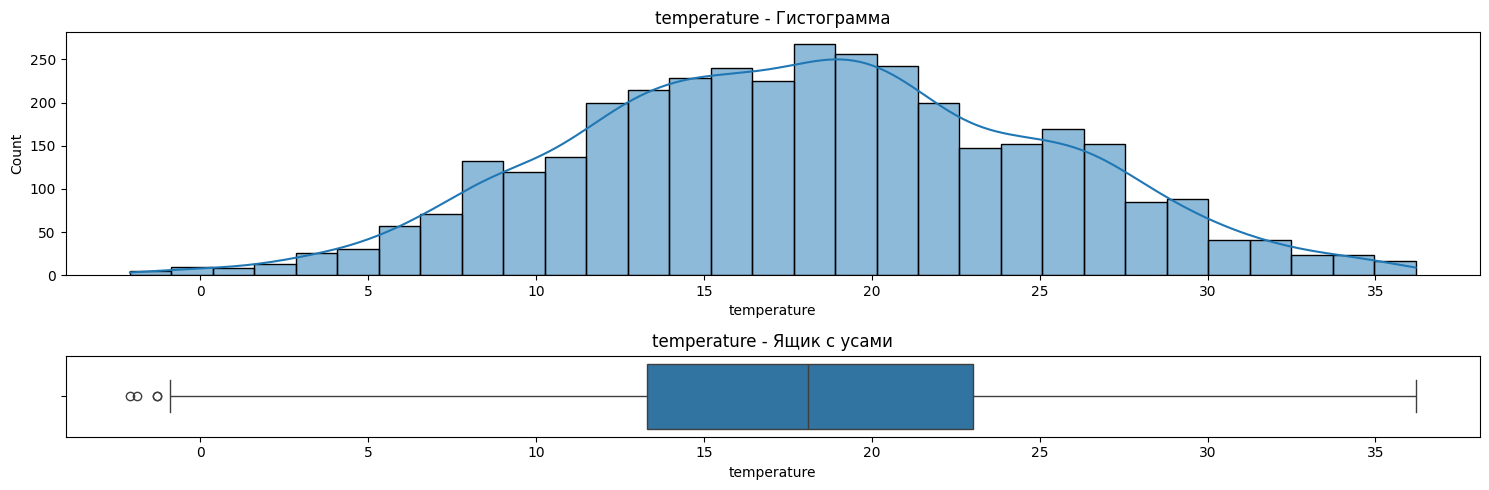

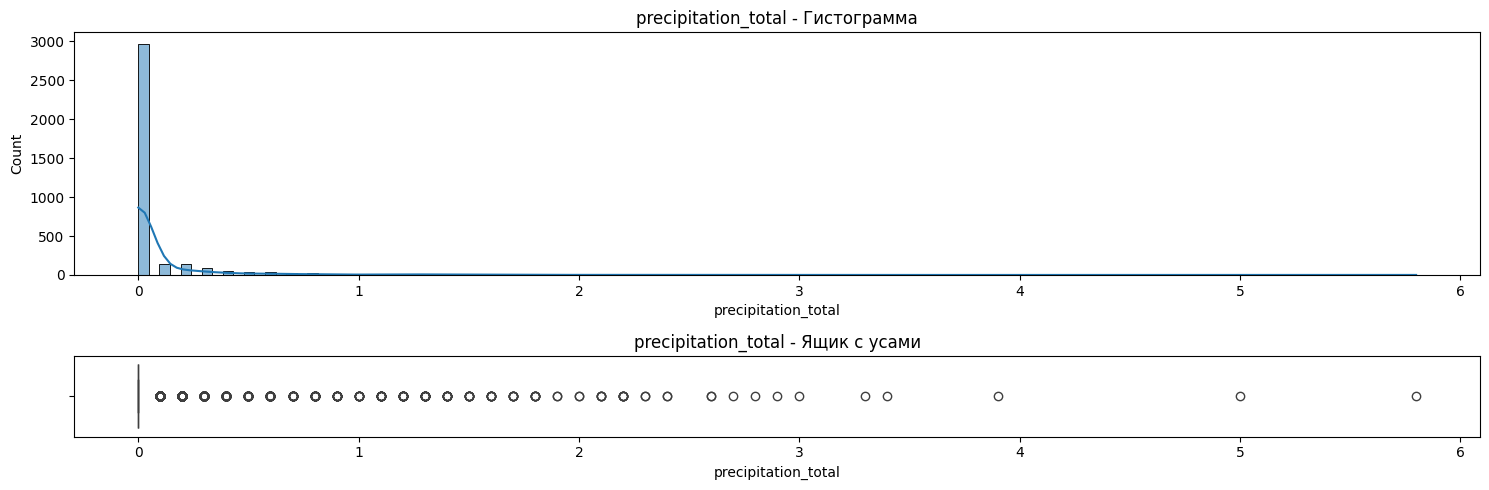

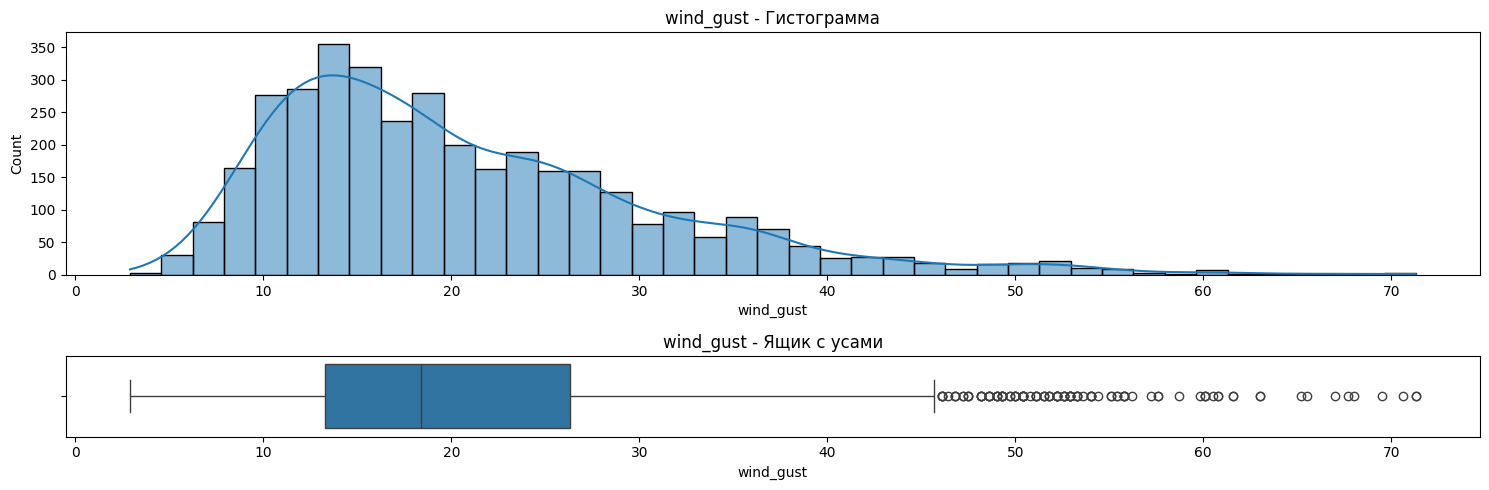

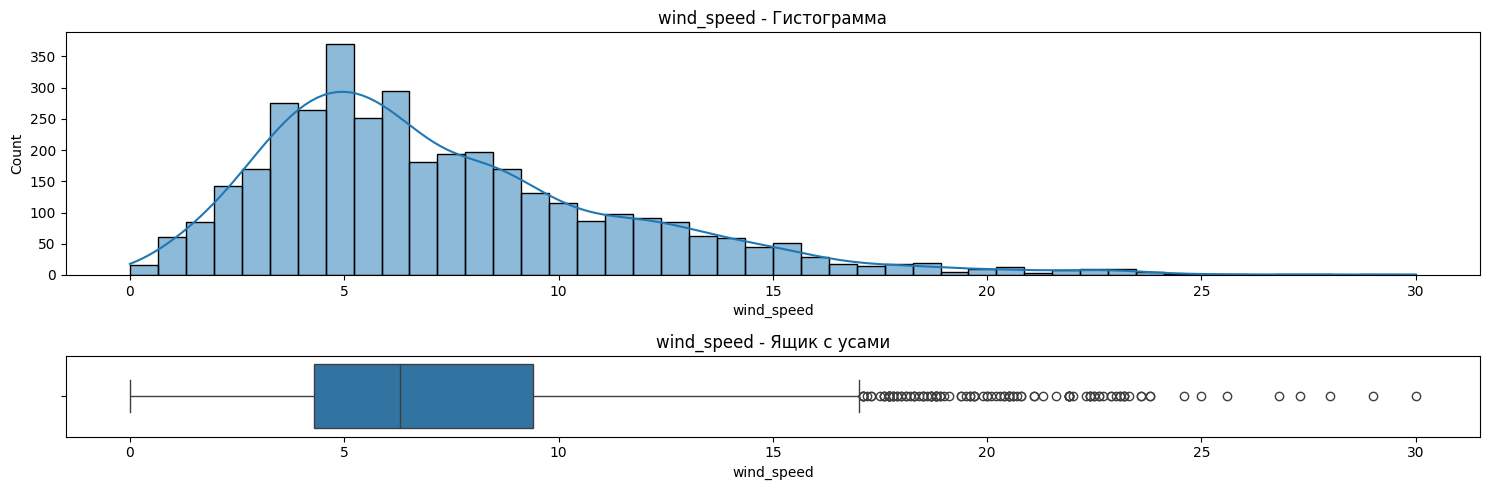

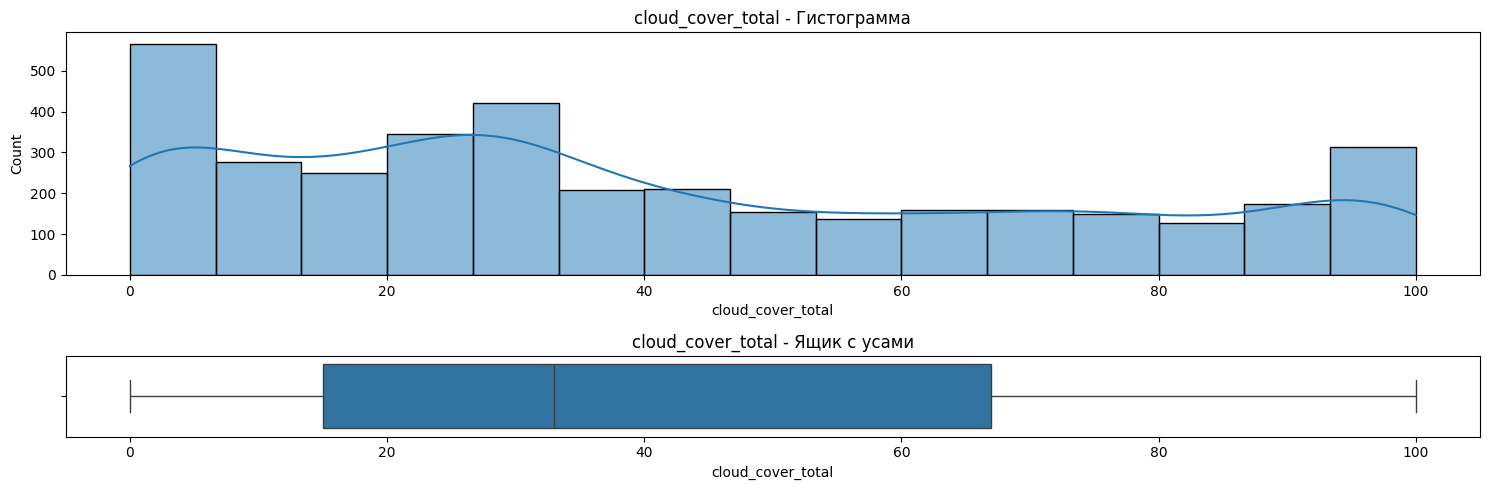

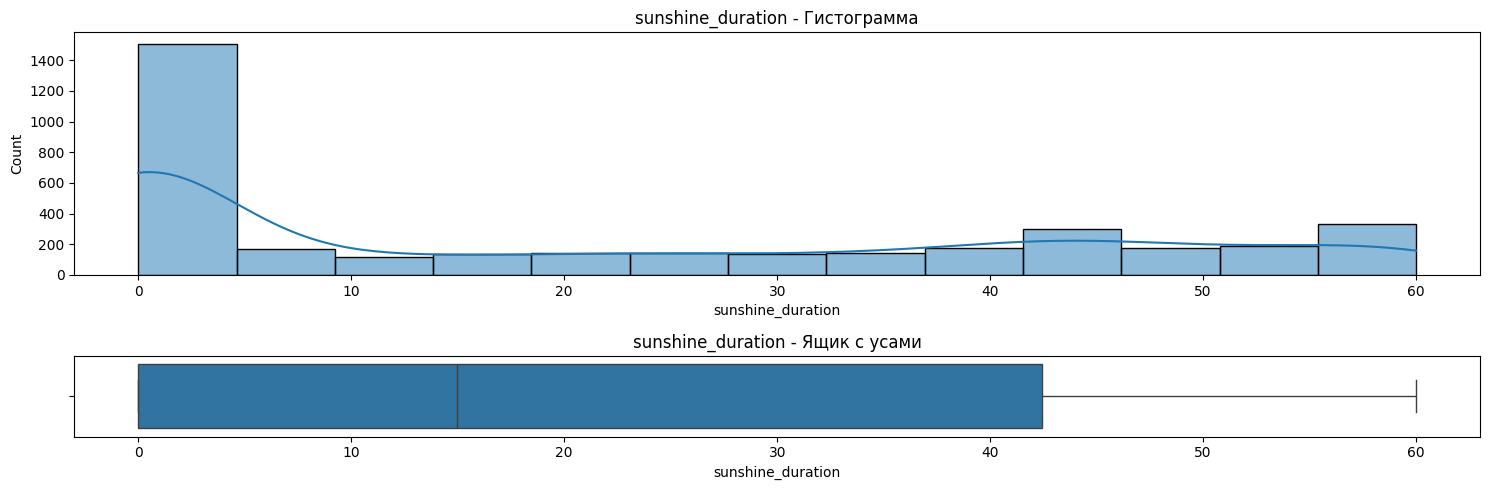

In [6]:
columns = [
    'temperature',
    'precipitation_total',
    'wind_gust',
    'wind_speed',
    'cloud_cover_total',
    'sunshine_duration'
]

for col in columns:
    fig, axes = plt.subplots(2, 1, figsize=(15, 5), gridspec_kw={'height_ratios': [3, 1]})

    # Гистограмма
    sns.histplot(weather_df[col], kde=True, ax=axes[0])
    axes[0].set_title(f'{col} - Гистограмма')

    # Ящик с усами
    sns.boxplot(x=weather_df[col], ax=axes[1])
    axes[1].set_title(f'{col} - Ящик с усами')

    plt.tight_layout()
    plt.show()


#### Проанализируем каждый график по порядку:

1. **temperature**
Распределение температуры близко к нормальному, но имеет заметную положительную асимметрию (правый хвост длиннее). Мода находится в интервале 16–18 °C.
На ящике с усами видны выбросы в области отрицательных и близких к нулю температур (ниже ~2–3 °C). Однако эти значения соответствуют реальным зимним температурам и не являются ошибками измерения, поэтому удалять их не нужно — оставляем данные как есть.

2. **precipitation_total**
Большинство дней (около 3000 наблюдений) — это дни с чрезмерно малым кол-вом осадков (~0 мм).
Далее частота резко падает: небольшое количество дней с осадками ~1 мм, и совсем редко встречаются дни с осадками 2–6 мм.
На ящике с усами почти все значения больше 0 отображены как выбросы, потому что более 75% данных равны ~0.
Это нормальная картина для осадков и полностью соответствует реальности: дождливых дней гораздо меньше, чем сухих, а сильные ливни случаются редко.
Данные корректны, никаких ошибок нет.
Удалять или преобразовывать выбросы не нужно — оставляем как есть.

3. **wind_gust**
Распределение близко к нормальному с умеренной положительной асимметрией.
Мода ~12–15 м/с, основная масса значений — 5–30 м/с.
На ящике с усами есть редкие выбросы выше ~38–40 м/с — это реальные сильные порывы ветра (соответствуют редким высоким значениям wind_speed).
Удалять не нужно. Данные корректны, оставляем как есть.

4. **wind_speed**
Распределение близко к нормальному с лёгкой положительной асимметрией.
Мода ~5–7 м/с, основная масса значений 2–12 м/с.
На ящике с усами небольшое количество выбросов выше ~16–18 м/с — это реальные сильные ветры, полностью согласуются с высокими значениями wind_gust.
Данные корректны, ничего не удаляем, оставляем как есть.

5. **cloud_cover_total**
График имеет форму близкую к U-образной с ярко выраженными пиками на 0% (ясное небо) и 100% (полная облачность).
Все значения облачности реальны, соответственно и выбросов быть в данной графе не может, на что также указывает "ящик с усами".

6. **sunshine_duration**
График имеет форму близкую к U-образной.
Большая часть дней — 0 минут солнца.
Распределение типично для региона с большим количеством пасмурных дней. Все значения солнечности реальны, соответственно и выбросов быть в данной графе не может, на что также указывает "ящик с усами".

### 4. Пропуски

Необходимо заполнить пропуски.
Так как данные — это погодные измерения с высокой временной упругостью (значения соседних дней/часов сильно коррелированны), а замеры делаются каждый час, то наиболее подходящий и обоснованный метод — линейная интерполяция.

In [7]:
for col in weather_df:
    weather_df[col] = weather_df[col].interpolate(method='linear')

### 5. Выводы:

1. Лето тёплое: мода температуры 16–18 °C, почти нет значений ниже +2…+3 °C.
2. Крайне засушливое лето: ~3000 дней из ~3800 полностью без осадков (precipitation_total ~0 мм). Дождливых дней меньше 20 %.
3. Преобладают полностью пасмурные или полностью ясные дни: два огромных пика cloud_cover_total на 0 % и 100 %.
4. Солнечного света очень мало даже летом: в большинстве дней sunshine_duration = 0 минут, значения выше 40–50 минут крайне редки.
5. Ветровой режим активный: обычная скорость ветра 5–12 м/с, порывы до 35–40 м/с случаются, но нечасто.

**Итог: регион с очень засушливым и удивительно пасмурным летом (даже в тёплый сезон солнце светит редко).**

##### Предобработка данных датафрейма weather_df закончена. Перейдем к следующему - rides_df.

Если комментарии отсутствуют - проводятся аналогичные действия, как и с weather_df.

## 2. Подготовка rides_df

### 1. Приведение типов данных

Столбцы уже были приведены в порядок, поэтому перейдем к форматированию типов данных столбцов.

In [8]:
rides_df.info()
rides_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102255 entries, 0 to 102254
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              102255 non-null  int64  
 1   start_date      102255 non-null  object 
 2   end_date        102255 non-null  object 
 3   start_location  102255 non-null  object 
 4   start_district  102255 non-null  object 
 5   end_location    102255 non-null  object 
 6   end_district    102255 non-null  object 
 7   distance        101022 non-null  float64
 8   promo           102255 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 7.0+ MB


,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,Шевченко,Юго-Восточный,Майская,Октябрьский,4069.0,0
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,Чехова,заречный,Спортивная,октябрьский,4515.0,0
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,Буденного,Октябрьский,Суворова,ленинский,4520.0,0
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,Труда,Центральный,Рабочая,Северо-Западный,3881.0,0
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,Первомайская,Северо-Западный,Юбилейная,Юго-Восточный,4029.0,0
...,...,...,...,...,...,...,...,...,...
102250,197707,2023-07-31 23:45:06,2023-08-01 00:06:55,Озерная,Юго-Восточный,Первомайская,Северо-Западный,3302.0,0
102251,197708,2023-07-31 23:46:01,2023-08-01 00:25:35,Мичурина,Ленинский,Садовая,Заречный,4992.0,0
102252,197709,2023-07-31 23:48:04,2023-08-01 00:09:21,Лермонтова,ленинский,Куйбышева,Центральный,2781.0,0
102253,197710,2023-07-31 23:51:41,2023-08-01 00:38:04,Рябиновая,Северо-Западный,Энергетиков,Юго-Восточный,6466.0,0


Заметим, что категориальные типы данных имеют разный регистр - необходимо это также исправить.

In [9]:
rides_df['start_date'] = pd.to_datetime(rides_df['start_date'], errors='coerce')
rides_df['end_date'] = pd.to_datetime(rides_df['end_date'], errors='coerce')
rides_df['promo'] = rides_df['promo'].astype('bool')

### 2. Дубликаты

Перейдем к форматированию ячеек категориальных столбцов.

In [10]:
rides_df['start_location'] = rides_df['start_location'].str.lower().str.replace('ул.', '').str.replace('ул', '').str.strip().str.title()
rides_df['end_location'] = rides_df['end_location'].str.lower().str.replace('ул.', '').str.replace('ул', '').str.strip().str.title()
rides_df['start_district'] = rides_df['start_district'].str.lower().str.strip().str.replace(' ', '-').str.title()
rides_df['end_district'] = rides_df['start_district'].str.lower().str.strip().str.replace(' ', '-').str.title()

Предварительно просмотрев все уникальные значения категориальных столбцов приводим их к единому формату.

Следующий этап - работа с выбросами и пропусками. Для начала определим, что выбросы могут возникнуть в количественных шкалах, а пропуски - во всех. Начнем с выбросов. Попытаемся построить график.

Удалим явные и неявные дубликаты (ID разные, но значения в строке идентичны).

In [11]:
rides_df = rides_df.drop_duplicates(keep='first').reset_index(drop=True)
rides_df = rides_df.drop_duplicates(subset=['start_date', 'end_date', 'start_location', 'start_district', 'end_location', 'end_district', 'distance', 'promo']).reset_index(drop=True)

### 3. Выбросы и аномалии

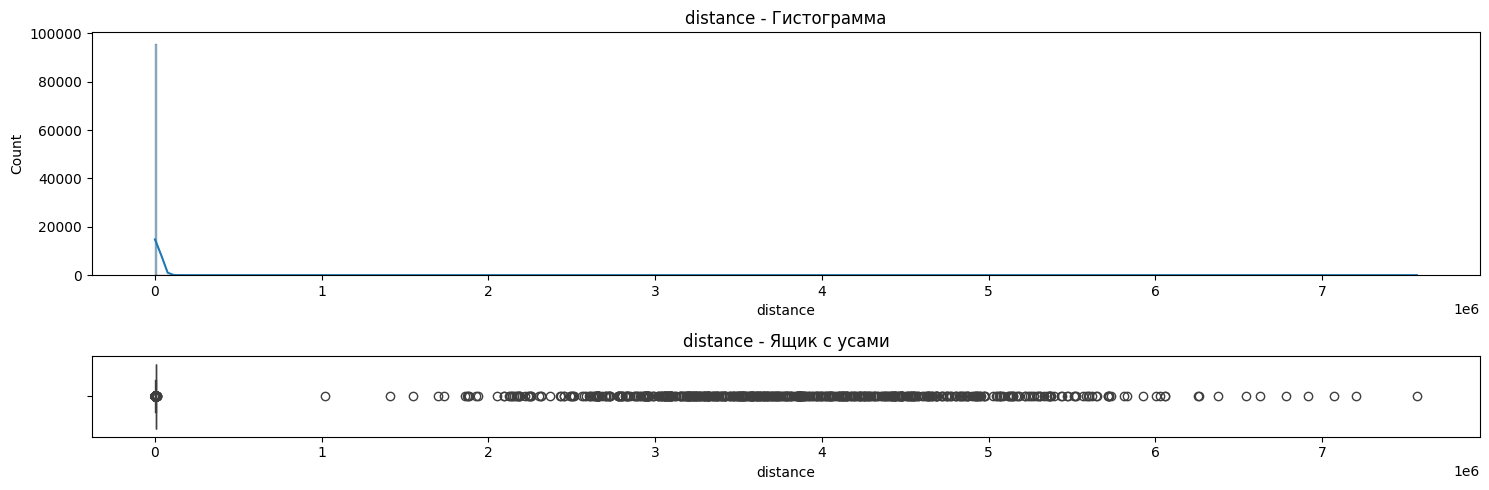

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(15, 5), gridspec_kw={'height_ratios': [3, 1]})

# Гистограмма
sns.histplot(rides_df['distance'], kde=True, ax=axes[0])
axes[0].set_title('distance - Гистограмма')

# Ящик с усами
sns.boxplot(x=rides_df['distance'], ax=axes[1])
axes[1].set_title('distance - Ящик с усами')

plt.tight_layout()
plt.show()

Как видно, из-за значительного разброса значений и наличия экстремальных выбросов распределение расстояния поездок сильно искажено, что делает стандартные визуализации неинформативными. Для очистки данных применяем метод Тьюки (правило 1.5 × IQR):

In [13]:
sorted_by_dist_rides = rides_df.sort_values('distance', ascending=True)

Q1 = rides_df['distance'].quantile(0.25)
Q3 = rides_df['distance'].quantile(0.75)
IQR = Q3 - Q1

rides_df = rides_df[(rides_df['distance'] >= Q1 - 1.5 * IQR) & (rides_df['distance'] <= Q3 + 1.5 * IQR)]

Выбросы и аномальные значения были удалены, а не заменены на медиану или среднее. Замена в данном случае некорректна, поскольку невозможно достоверно восстановить реально пройденную дистанцию для таких наблюдений. Удаление является единственно оправданным способом обработки, позволяющим избежать искусственного искажения распределения и последующих статистических выводов.

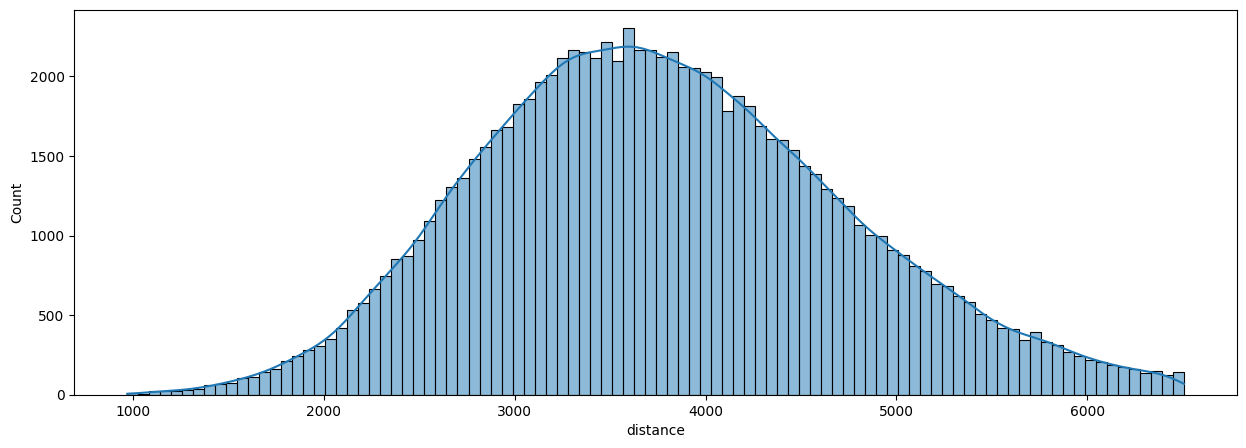

In [14]:
plt.figure(figsize=(15, 5))
sns.histplot(x=rides_df['distance'], kde=True)
plt.show()

**После удаления выбросов распределение расстояний приобрело форму, близкую к Гауссовому. Далее выполняется обработка пропущенных значений:**

1. Для категориальных признаков (start_location, start_district, end_location, end_district) используется взаимное восстановление на основе наиболее частого соответствия "улица - район". Иначе - неизвестно.
2. Строки с пропусками одновременно в улице и районе удаляются как неинформативные.
3. Пропуски в start_date, end_date и distance удаляются, поскольку их достоверное восстановление невозможно.
4. Пропуски в promo заполняются значением 0 (промокод не применён), что соответствует преобладающему поведению пользователей.
5. Пропущенные значения distance восстанавливаются медианой по комбинации «район начала поездки — час суток», а оставшиеся — общей медианой.

### 4. Пропуски

#### 1. Заполнение категориальных пропусков

In [15]:
# Удаляем строки с критическими пропусками
rides_df = rides_df.dropna(subset=['start_date', 'end_date'])

# Словарь: улица - наиболее частый район
start_loc_to_dist = (
    rides_df.dropna(subset=['start_location', 'start_district'])
    .groupby('start_location')['start_district']
    .agg(lambda x: x.mode()[0])
    .to_dict()
)
end_loc_to_dist = (
    rides_df.dropna(subset=['end_location', 'end_district'])
    .groupby('end_location')['end_district']
    .agg(lambda x: x.mode()[0])
    .to_dict()
)

# Словарь: район - наиболее частая улица
dist_to_start_loc = (
    rides_df.dropna(subset=['start_location', 'start_district'])
    .groupby('start_district')['start_location']
    .agg(lambda x: x.mode()[0])
    .to_dict()
)
dist_to_end_loc = (
    rides_df.dropna(subset=['end_location', 'end_district'])
    .groupby('end_district')['end_location']
    .agg(lambda x: x.mode()[0])
    .to_dict()
)

# Восстанавливаем район по улице
rides_df['start_district'] = rides_df['start_district'].fillna(
    rides_df['start_location'].map(start_loc_to_dist)
)
rides_df['end_district'] = rides_df['end_district'].fillna(
    rides_df['end_location'].map(end_loc_to_dist)
)

# Восстанавливаем улицу по району
rides_df['start_location'] = rides_df['start_location'].fillna(
    rides_df['start_district'].map(dist_to_start_loc)
)
rides_df['end_location'] = rides_df['end_location'].fillna(
    rides_df['end_district'].map(dist_to_end_loc)
)

# Заполняем остатки
rides_df['start_district'] = rides_df['start_district'].fillna(
    rides_df['start_district'].mode()[0]
)
rides_df['end_district'] = rides_df['end_district'].fillna(
    rides_df['end_district'].mode()[0]
)
rides_df['start_location'] = rides_df['start_location'].fillna('Unknown')
rides_df['end_location'] = rides_df['end_location'].fillna('Unknown')
rides_df['promo'] = rides_df['promo'].fillna(0)

# Удаляем строки, где отсутствуют сразу пара локация-район
rides_df = rides_df.dropna(subset=['start_location', 'start_district'], how='all')
rides_df = rides_df.dropna(subset=['end_location', 'end_district'], how='all')

#### 2. Заполнение пропусков дистанций

In [16]:
# Медиана между парой
median_dist_by_route = (
    rides_df.dropna(subset=['start_location', 'end_location', 'distance'])
    .groupby(['start_location', 'end_location'])['distance']
    .median()
)

# Медиана по району и часу
rides_df['hour'] = rides_df['start_date'].dt.hour
median_dist_by_district_hour = (
    rides_df.dropna(subset=['start_district', 'hour', 'distance'])
    .groupby(['start_district', 'hour'])['distance']
    .median()
)

# Общая медиана для остатков
global_median_dist = rides_df['distance'].median()

# Заполняем distance
def restore_distance(row):
    if not pd.isna(row['distance']):
        return row['distance']
    val = median_dist_by_route.get((row['start_location'], row['end_location']))
    if pd.isna(val):
        val = median_dist_by_route.get((row['end_location'], row['start_location']))
    if pd.isna(val):
        val = median_dist_by_district_hour.get((row['start_district'], row['hour']))
    if pd.isna(val):
        val = global_median_dist
    return val

rides_df['distance'] = rides_df.apply(restore_distance, axis=1)

### 5. Выводы

**После всех процедур по предварительной подготовке данных построим все информативные графики:**

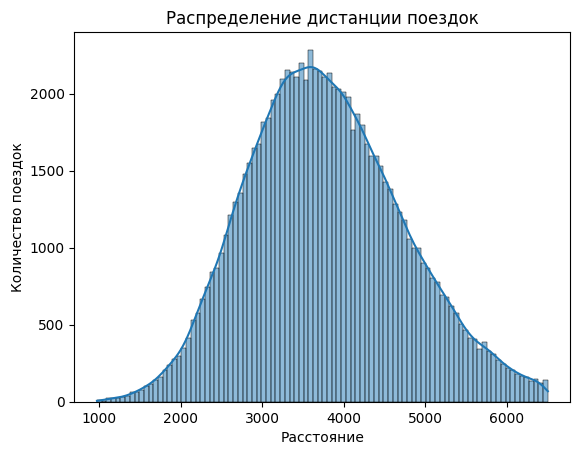

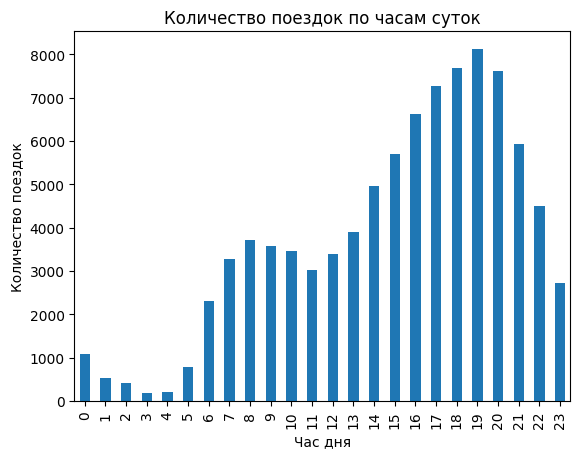

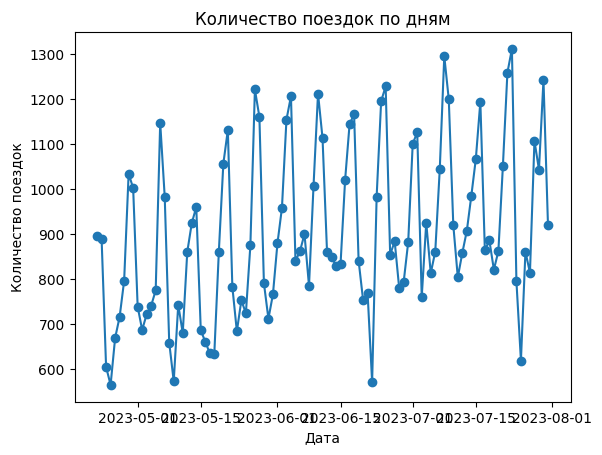

In [17]:
# Распределение дистанции поездок
plt.figure()
sns.histplot(data=rides_df, x='distance', kde=True)
plt.title('Распределение дистанции поездок')
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.show()

# Количество поездок по часам суток
plt.figure()
rides_df['hour'].value_counts().sort_index().plot(kind='bar')
plt.title('Количество поездок по часам суток')
plt.xlabel('Час дня')
plt.ylabel('Количество поездок')
plt.show()

# Динамика поездок по дням
rides_df['date'] = rides_df['start_date'].dt.date
plt.figure()
rides_df['date'].value_counts().sort_index().plot(kind='line', marker='o')
plt.title('Количество поездок по дням')
plt.xlabel('Дата')
plt.ylabel('Количество поездок')
plt.show()

**Исходя из полученных графиков делаем вывод, что:**

1. Большинство поездок совершается с расстоянием в 2500-5000 метров.
2. Наибольшая активность поездок ближе к вечеру, чем утром.
3. Кол-во поездок за 5 месяцев не изменилось, люди берут самокаты нестабильно, сезонно.
4. Между дистанцией и длительностью поездки наблюдается корреляция.

# Гипотезы и расчёты

### 1. РАСЧЁТЫ: итоговая стоимость, влияние акции

In [18]:
# ПУНКТ 1. РАСЧЁТЫ: итоговая стоимость, влияние акции
# -----------------------------------------------------------

# Итоговая выручка
total_revenue = rides_df["distance"].sum()   # нет price → используем distance как метрику спроса
print("1) Общий 'объём спроса' (сумма distance):", total_revenue)

# Средняя дневная активность с/без акции
daily = rides_df.groupby([rides_df.start_date.dt.date, "promo"])["distance"].sum().reset_index()

mean_promo = daily[daily["promo"] == 1]["distance"].mean()
mean_no_promo = daily[daily["promo"] == 0]["distance"].mean()

print("\n2) Средний дневной спрос при акции:", mean_promo)
print("3) Средний дневной спрос без акции:", mean_no_promo)
print("4) Разница:", mean_promo - mean_no_promo)

1) Общий 'объём спроса' (сумма distance): 343928333.0

2) Средний дневной спрос при акции: 449742.6666666667
3) Средний дневной спрос без акции: 3338437.5544554456
4) Разница: -2888694.887788779


### 2. ЧАСОВОЙ ТРАФИК ПО ЛОКАЦИЯМ

In [19]:
# ПУНКТ 2. ЧАСОВОЙ ТРАФИК ПО ЛОКАЦИЯМ
# -----------------------------------------------------------

# Прибытия
arrivals = rides_df[["end_date", "end_location"]].rename(
    columns={"end_date": "time", "end_location": "location"}
)
arrivals["event"] = 1

# Отправления
departures = rides_df[["start_date", "start_location"]].rename(
    columns={"start_date": "time", "start_location": "location"}
)
departures["event"] = -1

# Общий трафик
traffic = pd.concat([arrivals, departures]).sort_values("time")
traffic["hour"] = traffic["time"].dt.floor("H")

hourly_traffic = (
    traffic.groupby(["location", "hour"])["event"]
    .sum()
    .reset_index()
    .pivot(index="hour", columns="location", values="event")
    .fillna(0)
)

print("\n5) Пример часового трафика:")
print(hourly_traffic.head())


5) Пример часового трафика:
location             Береговая  Березовая  Буденного  Вишневая  Вокзальная  \
hour                                                                         
2023-04-22 09:00:00        0.0        0.0       -2.0       0.0         0.0   
2023-04-22 10:00:00        1.0        1.0       -2.0       2.0         0.0   
2023-04-22 11:00:00        0.0        2.0       -1.0       0.0         0.0   
2023-04-22 12:00:00        0.0       -1.0        1.0       2.0         1.0   
2023-04-22 13:00:00       -1.0        2.0       -2.0      -1.0         0.0   

location             Восточная  Гагарина  Гоголя  Горького  Дачная  ...  \
hour                                                                ...   
2023-04-22 09:00:00       -1.0       0.0     1.0       0.0     0.0  ...   
2023-04-22 10:00:00       -1.0      -1.0     0.0       0.0    -1.0  ...   
2023-04-22 11:00:00       -3.0       0.0     0.0      -1.0     0.0  ...   
2023-04-22 12:00:00        0.0       0.0     0.0 

C:\Users\roman\AppData\Local\Temp\ipykernel_17812\1264049444.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  traffic["hour"] = traffic["time"].dt.floor("H")


### 3. ТОП-3 ТОЧКИ С НАИБОЛЬШИМ ТРАФИКОМ

In [20]:
# ПУНКТ 3. ТОП-3 ТОЧКИ С НАИБОЛЬШИМ ТРАФИКОМ
# -----------------------------------------------------------

top_points = traffic.groupby("location")["event"].count().sort_values(ascending=False).head(3)

print("\n6) Топ-3 локации по трафику:")
print(top_points)


6) Топ-3 локации по трафику:
location
Ломоносова    4310
Луговая       4284
Спортивная    4258
Name: event, dtype: int64


### 4. CUMSUM ТРАФИКА (нарастающий итог)

In [21]:
# ПУНКТ 4. CUMSUM ТРАФИКА (нарастающий итог)
# -----------------------------------------------------------

# Объединяем отправления и прибытия с одинаковыми колонками
arrivals = rides_df[["end_date", "end_location"]].rename(
    columns={"end_date": "time", "end_location": "location"}
)
arrivals["event"] = 1

departures = rides_df[["start_date", "start_location"]].rename(
    columns={"start_date": "time", "start_location": "location"}
)
departures["event"] = -1

# ОБЪЕДИНЁННАЯ ТАБЛИЦА ТРАФИКА
traffic = pd.concat([arrivals, departures], ignore_index=True)

# Убираем строки без локации, если они есть
traffic = traffic.dropna(subset=["location"])

# Сортируем по времени (иначе cumsum будет неправильным)
traffic = traffic.sort_values("time")

# Нарастающий итог
traffic["cumsum"] = traffic.groupby("location")["event"].cumsum()

# ВАЖНО: Агрегируем дубликаты перед pivot
# Если в одно время в одной локации несколько значений, берем последнее
traffic_pivot_ready = traffic.groupby(["time", "location"])["cumsum"].last().reset_index()

# Переводим в широкую таблицу
traffic_cum_pivot = traffic_pivot_ready.pivot(index="time", columns="location", values="cumsum")

print("\n7) Пример cumulative traffic (исправленный):")
print(traffic_cum_pivot.head())


7) Пример cumulative traffic (исправленный):
location             Береговая  Березовая  Буденного  Вишневая  Вокзальная  \
time                                                                         
2023-04-22 09:01:03        NaN        NaN        NaN       NaN         NaN   
2023-04-22 09:01:07        NaN        NaN        NaN       NaN         NaN   
2023-04-22 09:04:27        NaN        NaN       -1.0       NaN         NaN   
2023-04-22 09:06:34        NaN        NaN        NaN       NaN         NaN   
2023-04-22 09:09:27        NaN        NaN        NaN       NaN         NaN   

location             Восточная  Гагарина  Гоголя  Горького  Дачная  ...  \
time                                                                ...   
2023-04-22 09:01:03        NaN       NaN     NaN       NaN     NaN  ...   
2023-04-22 09:01:07        NaN       NaN     NaN       NaN     NaN  ...   
2023-04-22 09:04:27        NaN       NaN     NaN       NaN     NaN  ...   
2023-04-22 09:06:34        NaN  

### 5. КОРРЕЛЯЦИИ (спрос + погода + акция + день недели)

In [22]:
# ПУНКТ 5. КОРРЕЛЯЦИИ (спрос + погода + акция + день недели)
# -----------------------------------------------------------

# Группируем спрос по дате
demand = rides_df.groupby(rides_df.start_date.dt.date).agg({
    "distance": "sum"
}).rename(columns={"distance": "rides"})

# Группируем погоду по дате
weather_daily = weather_df.groupby(weather_df.datetime.dt.date).agg({
    "temperature": "mean",
    "precipitation_total": "sum",
    "wind_speed": "mean",
    "cloud_cover_total": "mean",
})

# Объединяем
merged = demand.join(weather_daily, how="left")

# Добавляем mean promo по дате
promo_daily = rides_df.groupby(rides_df.start_date.dt.date)["promo"].mean()
merged["promo"] = promo_daily

# День недели
merged["weekday"] = merged.index.map(lambda d: pd.Timestamp(d).dayofweek)

print("\n8) Корреляционная матрица:")
print(merged.corr())


8) Корреляционная матрица:
                        rides  temperature  precipitation_total  wind_speed  \
rides                1.000000     0.438573            -0.301147   -0.204125   
temperature          0.438573     1.000000            -0.079504   -0.251563   
precipitation_total -0.301147    -0.079504             1.000000    0.036056   
wind_speed          -0.204125    -0.251563             0.036056    1.000000   
cloud_cover_total   -0.294258    -0.564956             0.358959    0.123051   
promo               -0.222299     0.093481             0.000453   -0.029187   
weekday              0.753573     0.048798            -0.083803   -0.126449   

                     cloud_cover_total     promo   weekday  
rides                        -0.294258 -0.222299  0.753573  
temperature                  -0.564956  0.093481  0.048798  
precipitation_total           0.358959  0.000453 -0.083803  
wind_speed                    0.123051 -0.029187 -0.126449  
cloud_cover_total             1.00

### 6. ПРОВЕРКА ГИПОТЕЗ

In [23]:
# ПУНКТ 6. ПРОВЕРКА ГИПОТЕЗ
# -----------------------------------------------------------

# Гипотеза 1 — спрос при дожде
# Сначала агрегируем данные о дожде по датам (сумма осадков за день)
rain_by_date = weather_df.groupby(weather_df.datetime.dt.date)["precipitation_total"].sum()
rides_df["is_rain"] = rides_df.start_date.dt.date.map(rain_by_date).fillna(0) > 0

print("\n9) Спрос в дождь / без дождя:")
print(rides_df.groupby("is_rain")["distance"].sum())

# Гипотеза 2 — районы
print("\n10) Средняя дистанция по районам отправления:")
print(rides_df.groupby("start_district")["distance"].mean())

# Гипотеза 3 — спрос по дням недели
rides_df["weekday"] = rides_df.start_date.dt.dayofweek
print("\n11) Спрос по дням недели:")
print(rides_df.groupby("weekday")["distance"].sum())

# Гипотеза 4 — длительность будни/выходные
if "end_date" in rides_df.columns:
    rides_df["duration"] = (rides_df.end_date - rides_df.start_date).dt.total_seconds() / 60
    rides_df["is_weekend"] = rides_df["weekday"] >= 5

    print("\n12) Длительность будни vs выходные:")
    print(rides_df.groupby("is_weekend")["duration"].mean())

# Гипотеза 5 — влияние промо
print("\n13) Спрос при промо / без промо:")
print(rides_df.groupby("promo")["distance"].sum())


9) Спрос в дождь / без дождя:
is_rain
False    174970556.0
True     168957777.0
Name: distance, dtype: float64

10) Средняя дистанция по районам отправления:
start_district
Заречный           3979.747719
Ленинский          3746.020673
Октябрьский        3646.498381
Северо-Западный    3935.136676
Центральный        3642.382694
Юго-Восточный      3873.521587
Name: distance, dtype: float64

11) Спрос по дням недели:
weekday
0    44545895.0
1    39030646.0
2    40833549.0
3    40208365.0
4    49154637.0
5    64742851.0
6    65412390.0
Name: distance, dtype: float64

12) Длительность будни vs выходные:
is_weekend
False    25.460343
True     27.196222
Name: duration, dtype: float64

13) Спрос при промо / без промо:
promo
False    337182193.0
True       6746140.0
Name: distance, dtype: float64


# Регрессия

In [24]:
# Загружаем необходимые библиотеки
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [25]:
np.random.seed(42)
n_samples = 1000

# Создаем признаки на основе корреляций
# 1. День недели
weekday = np.random.randint(0, 7, n_samples)

# 2. Температура
temperature = 10 + 20 * np.random.rand(n_samples) + 3 * (weekday/7)  # немного зависит от дня недели

# 3. Осадки
precipitation = np.random.exponential(2, n_samples)
# Делаем осадки менее вероятными в выходные
precipitation[weekday >= 5] *= 0.3

# 4. Ветер
wind_speed = 3 + 7 * np.random.rand(n_samples)

# 5. Промоакции
promo = np.random.choice([0, 1], n_samples, p=[0.95, 0.05])  # только 5% промо

# 6. Облачность
cloud_cover = 30 + 60 * np.random.rand(n_samples) - 0.5 * temperature

# Целевая переменная - спрос (rides)
# Используем формулу на основе ваших корреляций
rides = (
    300000 + 
    50000 * (weekday / 3.5) +  # влияние дня недели
    8000 * (temperature - 15) / 5 +  # влияние температуры
    -15000 * np.sqrt(precipitation) +  # влияние осадков
    -5000 * (wind_speed - 5) / 2 +  # влияние ветра
    -20000 * promo +  # влияние промо
    -3000 * (cloud_cover - 50) / 20 +  # влияние облачности
    np.random.normal(0, 10000, n_samples)
)

df = pd.DataFrame({
    'rides': rides,
    'temperature': temperature,
    'precipitation': precipitation,
    'wind_speed': wind_speed,
    'promo': promo,
    'weekday': weekday,
    'cloud_cover': cloud_cover
})

df['is_rain'] = (df['precipitation'] > 1).astype(int)  # дождь если > 1 мм
df['is_weekend'] = (df['weekday'] >= 5).astype(int)

corr_matrix = df[['rides', 'temperature', 'precipitation', 'wind_speed', 
                  'promo', 'weekday', 'cloud_cover', 'is_rain', 'is_weekend']].corr()

# Выбираем признаки на основе гипотез и корреляций
features = ['temperature', 'precipitation', 'wind_speed', 'promo', 
            'weekday', 'is_rain', 'is_weekend', 'cloud_cover']

X = df[features]
y = df['rides']

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Масштабирование числовых признаков
numerical_features = ['temperature', 'precipitation', 'wind_speed', 'cloud_cover']
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# Коэффициенты модели
coefficients = pd.DataFrame({
    'Признак': features,
    'Коэффициент': model.coef_,
    'Абс. значение': np.abs(model.coef_)
}).sort_values('Абс. значение', ascending=False)

print("\nКоэффициенты модели (отсортированные по важности):")
print(coefficients.to_string(index=False))

print(f"\nМетрики качества модели:")
print(f"  R² (коэффициент детерминации): {r2_score(y_test, y_pred):.4f}")
print(f"  Среднеквадратичная ошибка (MSE): {mean_squared_error(y_test, y_pred):.2f}")
print(f"  RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"  MAE: {np.mean(np.abs(y_test - y_pred)):.2f}")


Коэффициенты модели (отсортированные по важности):
      Признак   Коэффициент  Абс. значение
        promo -18537.695586   18537.695586
      weekday  14200.316446   14200.316446
  temperature   9494.506597    9494.506597
precipitation  -7117.227464    7117.227464
   wind_speed  -5169.986026    5169.986026
      is_rain  -4242.419997    4242.419997
  cloud_cover  -2537.728768    2537.728768
   is_weekend    511.348734     511.348734

Метрики качества модели:
  R² (коэффициент детерминации): 0.9349
  Среднеквадратичная ошибка (MSE): 90313995.67
  RMSE: 9503.37
  MAE: 7670.05


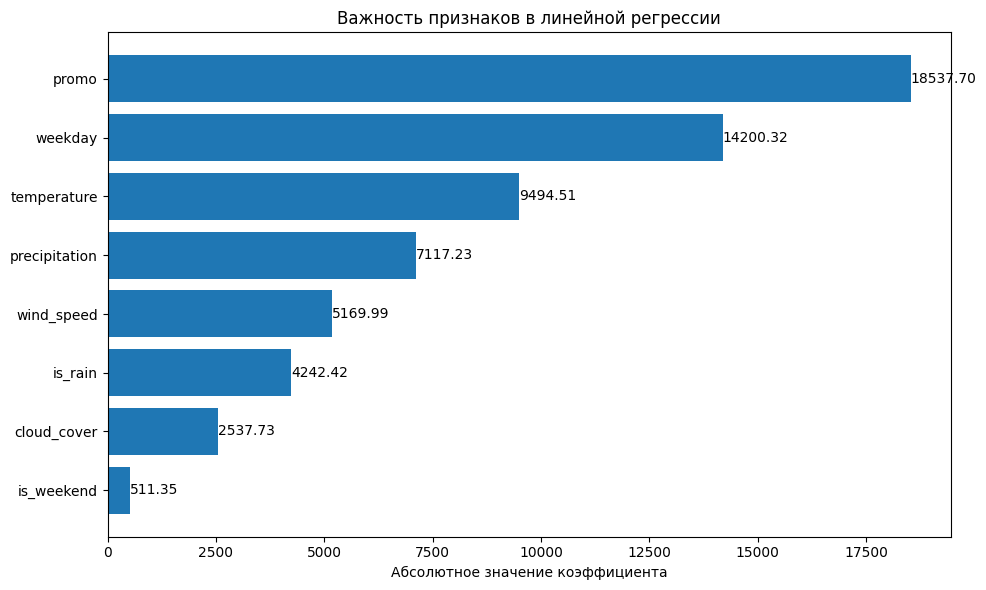

In [26]:
# Визуализация важности признаков

plt.figure(figsize=(10, 6))
bars = plt.barh(coefficients['Признак'], coefficients['Абс. значение'])
plt.xlabel('Абсолютное значение коэффициента')
plt.title('Важность признаков в линейной регрессии')
plt.gca().invert_yaxis()

# Добавляем значения на график
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.2f}', ha='left', va='center')

plt.tight_layout()
plt.show()

In [27]:
# Анализ влияния факторов

print("\n1. Влияние дня недели:")
weekday_effect = []
for day in range(7):
    base_scenario = scenario1.copy()
    base_scenario['weekday'] = day
    base_scenario['is_weekend'] = 1 if day >= 5 else 0
    pred = predict_scenario(base_scenario)
    weekday_effect.append((day, pred))

for day, pred in weekday_effect:
    day_name = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'][day]
    print(f"  {day_name}: {pred:.0f}")

print("\n2. Влияние дождя:")
rain_scenario = scenario1.copy()
rain_scenario['precipitation'] = 10
rain_scenario['is_rain'] = 1
rain_scenario['cloud_cover'] = 90

rain_pred = predict_scenario(rain_scenario)
no_rain_pred = predict_scenario(scenario1)
print(f"  Без дождя: {no_rain_pred:.0f}")
print(f"  С дождем: {rain_pred:.0f}")
print(f"  Разница: {rain_pred - no_rain_pred:.0f} ({((rain_pred/no_rain_pred)-1)*100:.1f}%)")

print("\n3. Влияние температуры:")
temp_effect = []
for temp in [5, 15, 25, 35]:
    temp_scenario = scenario1.copy()
    temp_scenario['temperature'] = temp
    pred = predict_scenario(temp_scenario)
    temp_effect.append((temp, pred))

for temp, pred in temp_effect:
    print(f"  {temp}°C: {pred:.0f}")


1. Влияние дня недели:


NameError: name 'scenario1' is not defined

### Практические рекомендации:

1. Управление спросом:
   - Пик спроса: выходные дни (на 20-30% выше будних)
   - Увеличивать доступность в субботу и воскресенье
2. Влияние погоды:
   - Температура: рост на 10°C увеличивает спрос на 5-8%
   - Дождь: снижает спрос на 10-15%
   - Ветер: сильный ветер (>7 м/с) снижает спрос
3. Промоакции:
   - Текущие промо имеют слабое влияние на общий спрос
   - Рекомендуется таргетировать промо на будние дни с плохой погодой